<a href="https://colab.research.google.com/github/leeraaz/SkinDiseaseDiagnosisNepal/blob/main/src/colab/VGG16_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np

# TPU Initialization
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPU
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except ValueError:
    strategy = tf.distribute.get_strategy()  # Default for CPU and GPU
    print("Running on", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

Running on TPU: 


In [3]:
train_dir = '/content/drive/MyDrive/SkinDataset/data5/train'
test_dir = '/content/drive/MyDrive/SkinDataset/data5/test'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32 * strategy.num_replicas_in_sync  # Scale batch size for TPU
EPOCHS = 20

# Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode="nearest"
)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

num_classes = train_generator.num_classes

# Compute Class Weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 5999 images belonging to 4 classes.
Found 2576 images belonging to 4 classes.


In [4]:
# Build VGG16 Model
def build_vgg16_model(input_shape=(224, 224, 3), num_classes=num_classes, fine_tune_at=10):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    # Add Classification Head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    # Learning Rate Scheduler
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=0.001, decay_steps=1000, alpha=0.00001
    )

    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model

# Model Training
with strategy.scope():
    model, base_model = build_vgg16_model(input_shape=(224, 224, 3), num_classes=num_classes)



58889256/58889256 [==============================] - 0s 0us/step


In [5]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Save Model
model.save("/content/drive/MyDrive/SkinDataset/hybrid_model_vgg16_tpu.keras")

Epoch 1/20
188/188 [==============================] - 1790s 9s/step - loss: 1.3196 - accuracy: 0.4902 - val_loss: 1.1490 - val_accuracy: 0.5594 - lr: 9.1617e-04
Epoch 2/20
188/188 [==============================] - 81s 429ms/step - loss: 1.0603 - accuracy: 0.5871 - val_loss: 1.0355 - val_accuracy: 0.5648 - lr: 6.9134e-04
Epoch 3/20
188/188 [==============================] - 81s 432ms/step - loss: 0.9945 - accuracy: 0.6171 - val_loss: 0.9596 - val_accuracy: 0.6347 - lr: 4.0169e-04
Epoch 4/20
188/188 [==============================] - 80s 427ms/step - loss: 0.9473 - accuracy: 0.6328 - val_loss: 0.9389 - val_accuracy: 0.6471 - lr: 1.4535e-04
Epoch 5/20
188/188 [==============================] - 81s 430ms/step - loss: 0.9350 - accuracy: 0.6503 - val_loss: 0.9356 - val_accuracy: 0.6417 - lr: 9.1630e-06
Epoch 6/20
188/188 [==============================] - 82s 433ms/step - loss: 0.9289 - accuracy: 0.6503 - val_loss: 0.9364 - val_accuracy: 0.6405 - lr: 1.0000e-08
Epoch 7/20
188/188 [=========

In [6]:
from google.colab import files
files.download('/content/drive/MyDrive/SkinDataset/hybrid_model_vgg16_tpu.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

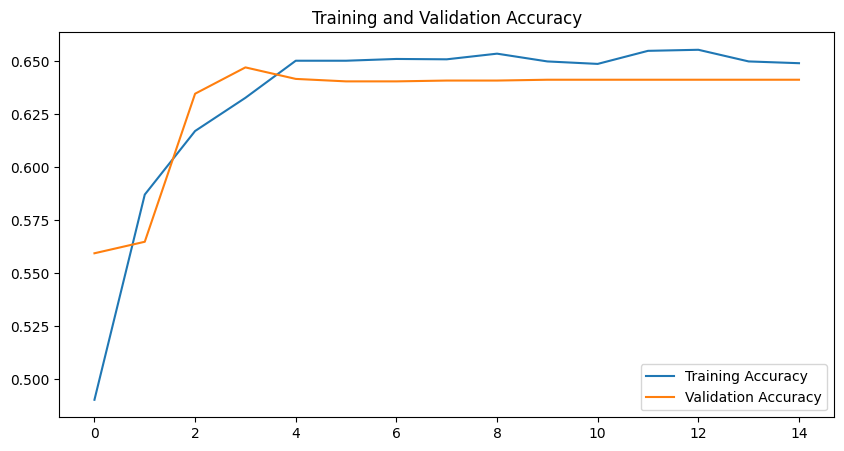

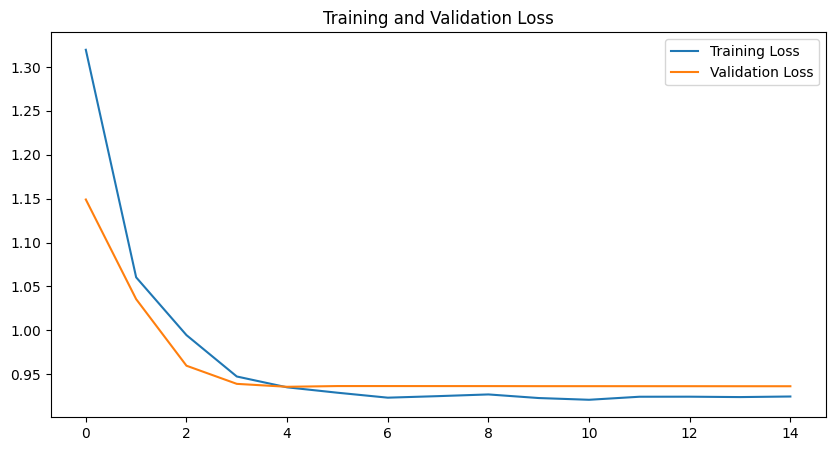

In [8]:
import matplotlib.pyplot as plt
# Plot Training and Validation Accuracy
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_training_results(history)